In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка датасета

In [2]:
train_df = pd.read_csv('train.csv', parse_dates=['Date'])
test_df = pd.read_csv('test.csv', parse_dates=['Date'])

In [3]:
train_df.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


In [4]:
train_df = train_df.drop(columns=['store', 'product'], axis=1)
test_df = test_df.drop(columns=['store', 'product'], axis=1)
train_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

In [5]:
train_df.head()

,number_sold
Date,
2010-01-01,801
2010-01-02,810
2010-01-03,818
2010-01-04,796
2010-01-05,808


# Отображение данных

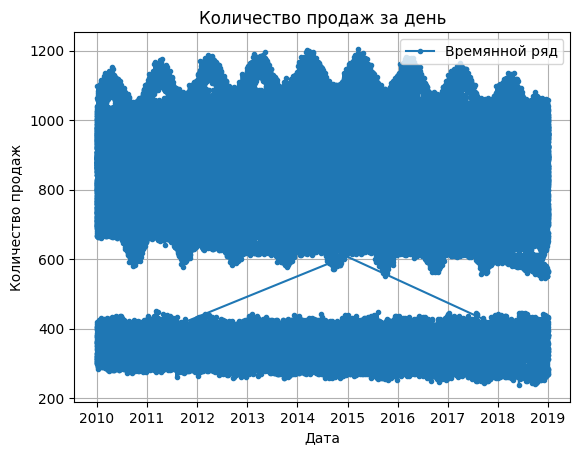

In [6]:
plt.plot(train_df.index, train_df['number_sold'], marker='.', label="Времянной ряд")
plt.title('Количество продаж за день')
plt.xlabel('Дата')
plt.ylabel('Количество продаж')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
train_df_week = train_df.resample('W').sum()
test_df_week = test_df.resample('W').sum()

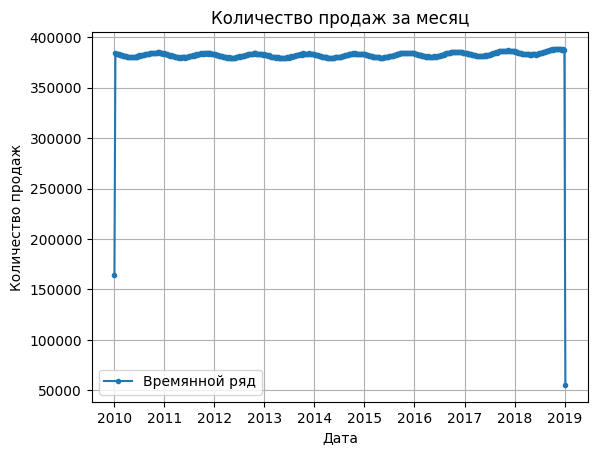

In [8]:
plt.plot(train_df_week.index, train_df_week['number_sold'], marker='.', label="Времянной ряд")
plt.title('Количество продаж за месяц')
plt.xlabel('Дата')
plt.ylabel('Количество продаж')
plt.legend()
plt.grid(True)
plt.show()

# Очистка от выбросов и заполнение пропусков



In [28]:
# Заполнение пропусков
train_df_week = train_df_week.bfill().ffill()
test_df_week = test_df_week.bfill().ffill()

In [29]:
# Функция для удаления выбросов
def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Границы для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Фильтрация выбросов
    filtered_series = series[(series >= lower_bound) & (series <= upper_bound)]

    return filtered_series

In [30]:
train_df_week['number_sold'] = remove_outliers(train_df_week['number_sold'])
test_df_week['number_sold'] = remove_outliers(test_df_week['number_sold'])

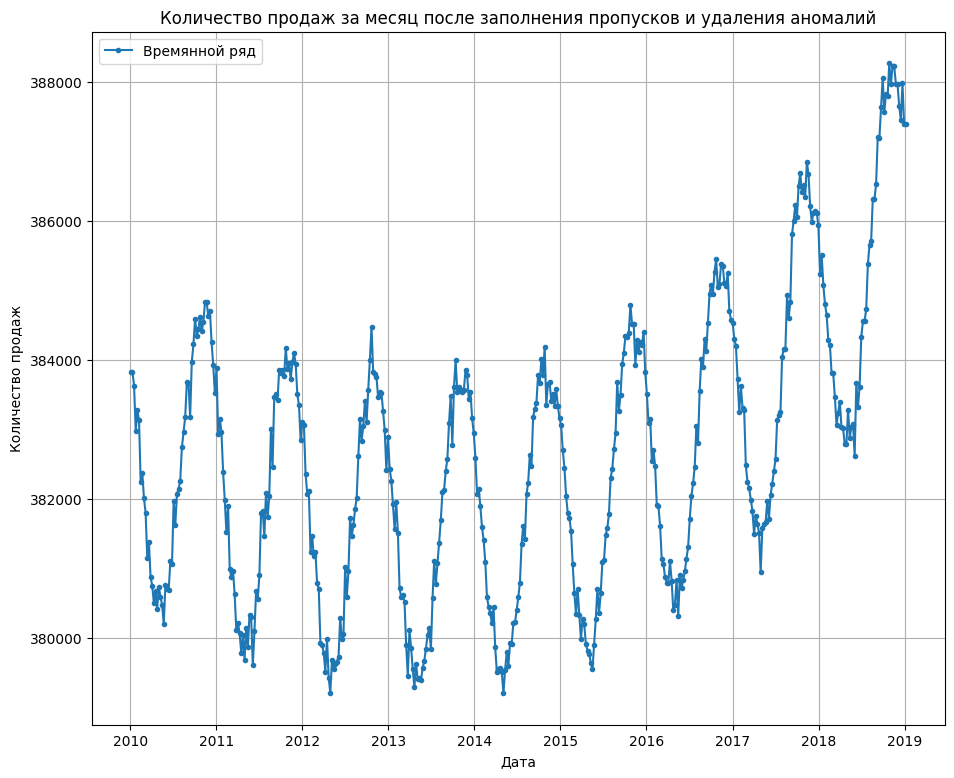

In [31]:
plt.plot(train_df_week.index, train_df_week['number_sold'], marker='.', label="Времянной ряд")
plt.title('Количество продаж за месяц после заполнения пропусков и удаления аномалий')
plt.xlabel('Дата')
plt.ylabel('Количество продаж')
plt.legend()
plt.grid(True)
plt.show()

# Декомпозирование ряда

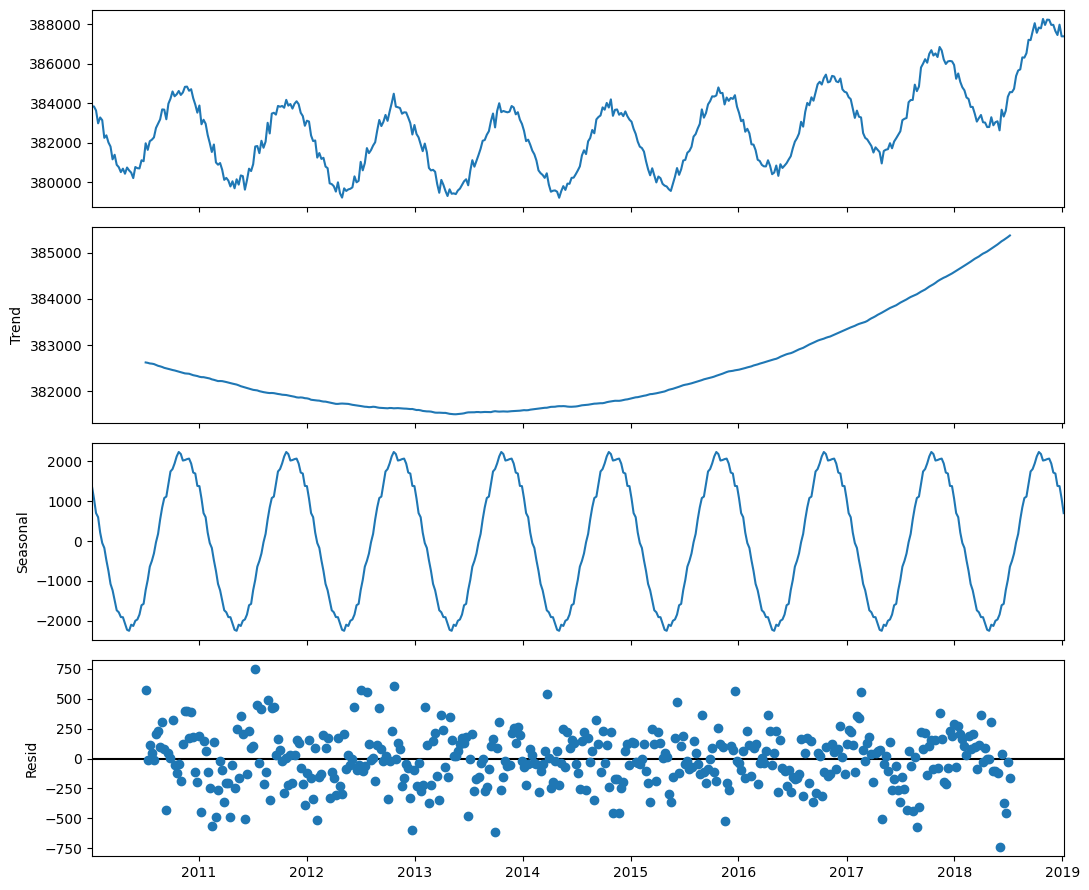

In [32]:
# импортируем функцию seasonal_decompose из statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

# применяем функцию к данным о перевозках
decompose = seasonal_decompose(train_df_week[['number_sold']])
decompose.plot()

plt.show()

# Наблюдения
Наблюдается ярко выраженая сезонность и тренд. Остатки разбросаны более менее случайно

# Проверка на стационарность тестом Дики Фулера

In [33]:
from statsmodels.tsa.stattools import adfuller

# Тест Дики-Фуллера до дифференцирования
result = adfuller(train_df_week)
print(f"p-value до дифференцирования: {result[1]}")

# Дифференцирование
train_df_week_diff = train_df_week.diff().dropna()

# Тест Дики-Фуллера после дифференцирования
result_after_diff = adfuller(train_df_week_diff)
print(f"p-value после дифференцирования: {result_after_diff[1]}")

p-value до дифференцирования: 0.8046598219711676
p-value после дифференцирования: 3.342737018951994e-20


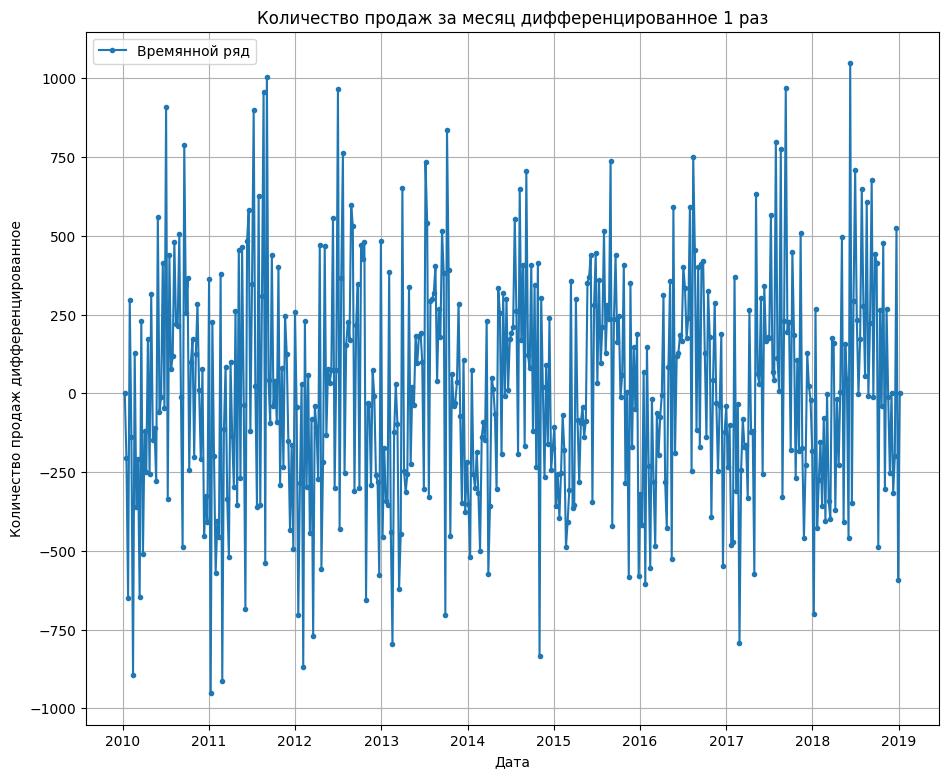

In [34]:
plt.plot(train_df_week_diff.index, train_df_week_diff['number_sold'], marker='.', label="Времянной ряд")
plt.title('Количество продаж за месяц дифференцированное 1 раз')
plt.xlabel('Дата')
plt.ylabel('Количество продаж дифференцированное')
plt.legend()
plt.grid(True)
plt.show()

После дифференцирования p-value сильно меньше 0.05 - то  есть после одного дифференцирования ряд стал стационарным

# Автокорреляция и частичная автокорреляция

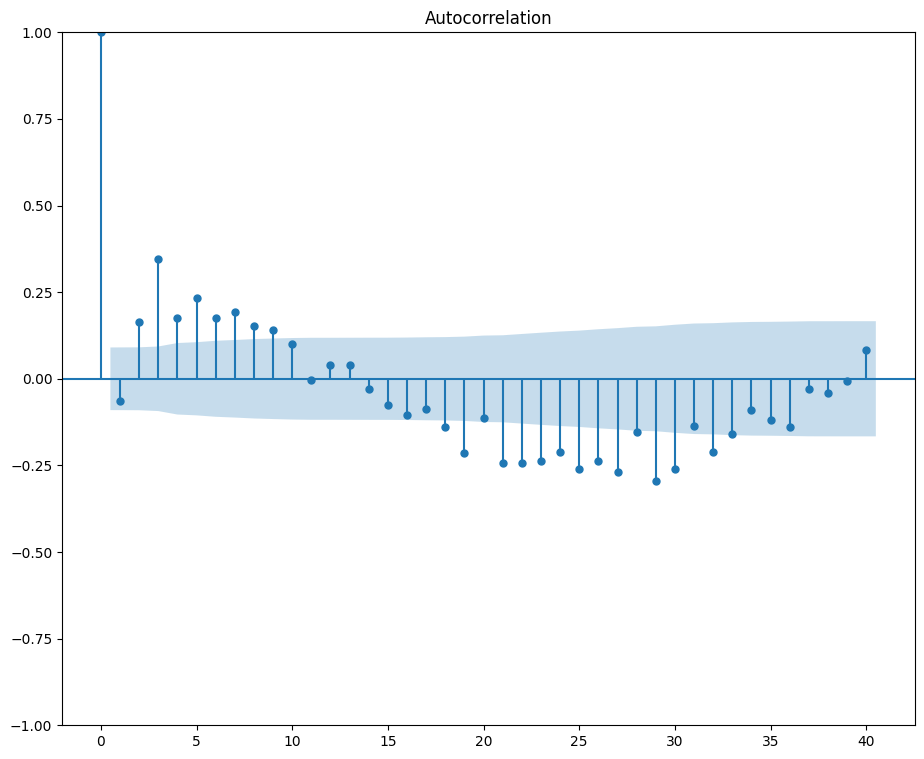

In [35]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(train_df_week_diff.values.squeeze(), lags=40)
plt.show()

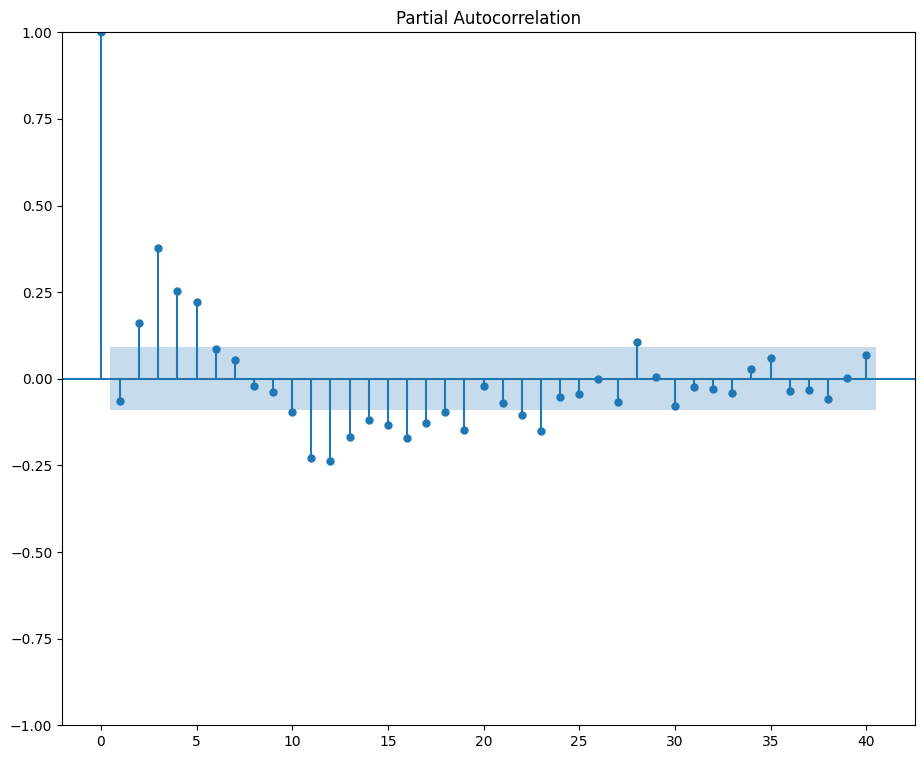

In [36]:
sm.graphics.tsa.plot_pacf(train_df_week_diff, lags=40)
plt.show()

# Построение модели ARIMA

In [37]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_df_week_diff, order=[25, 1, 5])
model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Прогнозирование на дифференцированных тестовых данных

In [38]:
forecast_df_week = model.forecast(steps=len(test_df_week))

In [39]:
last_train_value = train_df_week['number_sold'][-1]
forecast_df_week = forecast_df_week.cumsum() + last_train_value

<ipython-input-39-befe6a55fcf2>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_train_value = train_df_week['number_sold'][-1]


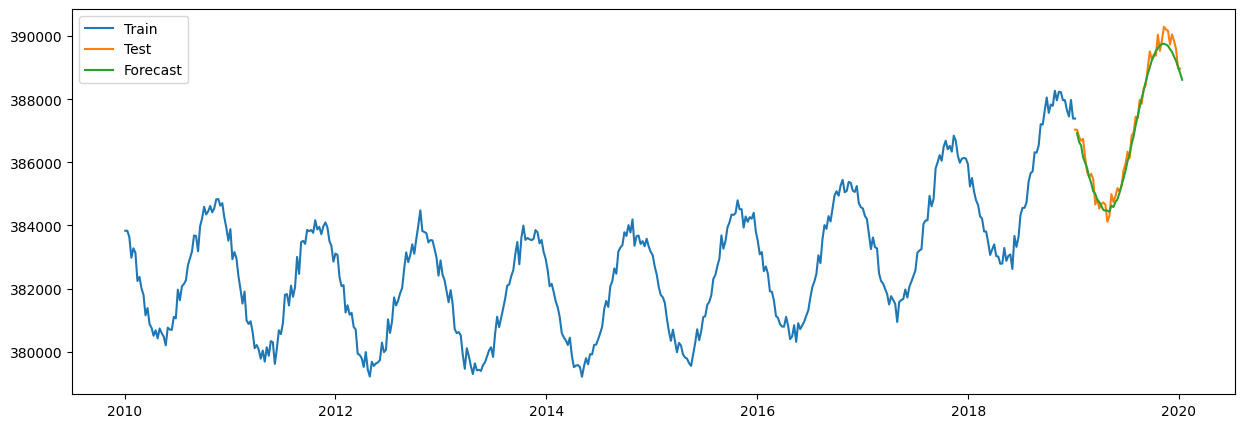

In [40]:
plt.figure(figsize=(15, 5))
plt.plot(train_df_week.index, train_df_week, label='Train')
plt.plot(test_df_week.index, test_df_week, label='Test')
plt.plot(forecast_df_week.index, forecast_df_week, label='Forecast')
plt.legend()
plt.show()

# Анализ остатков модели

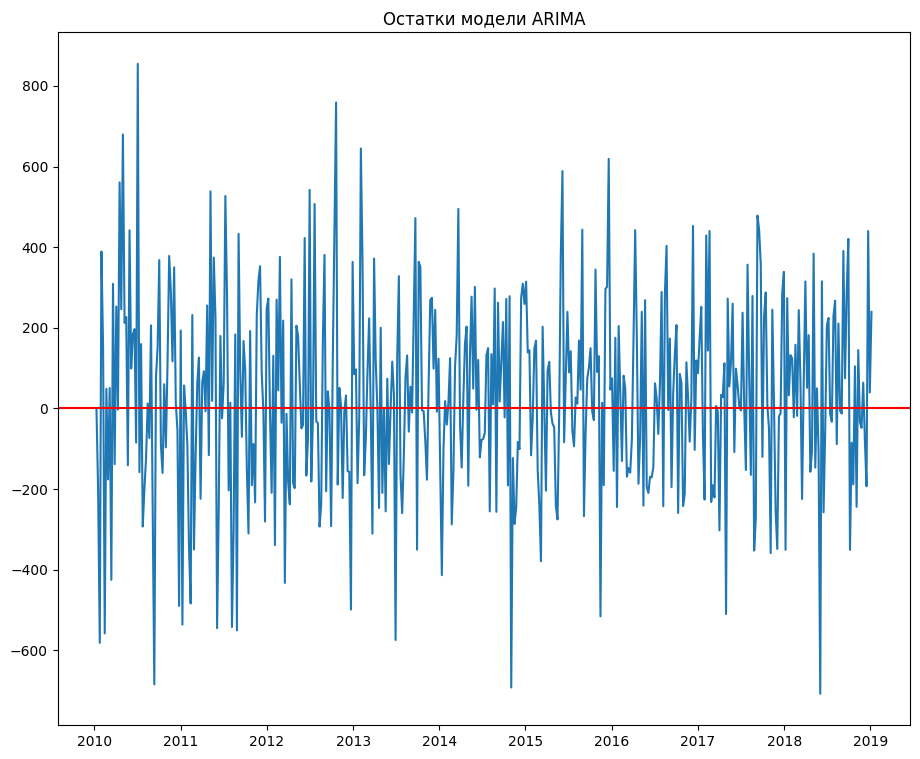

In [41]:
plt.plot(model.resid)
plt.title('Остатки модели ARIMA')
plt.axhline(y=0, color='r')
plt.show()

Остатки распределены достаточно нормально

# Метрики

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mse = mean_squared_error(test_df_week, forecast_df_week)
mae = mean_absolute_error(test_df_week, forecast_df_week)
r2 = r2_score(test_df_week, forecast_df_week)

print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")

MSE: 111969.61112906634, MAE: 274.55492254361434, R^2: 0.971832765837532


# Построение модели SARIMA

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_df_week_diff, order=[25, 1, 5], seasonal_order=[0, 0, 0, 12],  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Прогнозирование на дифференцированных тестовых данных

In [44]:
forecast_df_week = model.forecast(steps=len(test_df_week))

In [45]:
last_train_value = train_df_week['number_sold'][-1]
forecast_df_week = forecast_df_week.cumsum() + last_train_value

<ipython-input-45-befe6a55fcf2>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_train_value = train_df_week['number_sold'][-1]


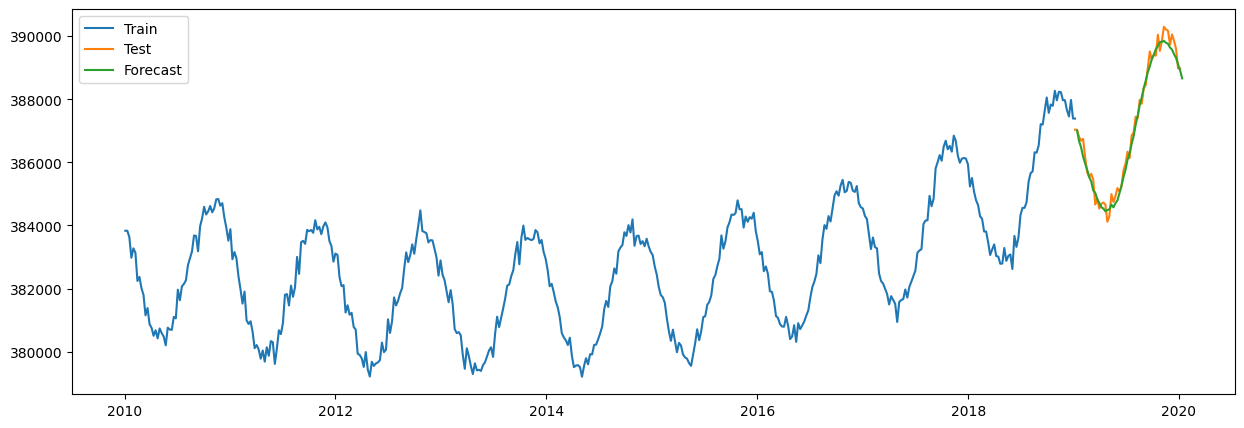

In [46]:
plt.figure(figsize=(15, 5))
plt.plot(train_df_week.index, train_df_week, label='Train')
plt.plot(test_df_week.index, test_df_week, label='Test')
plt.plot(forecast_df_week.index, forecast_df_week, label='Forecast')
plt.legend()
plt.show()

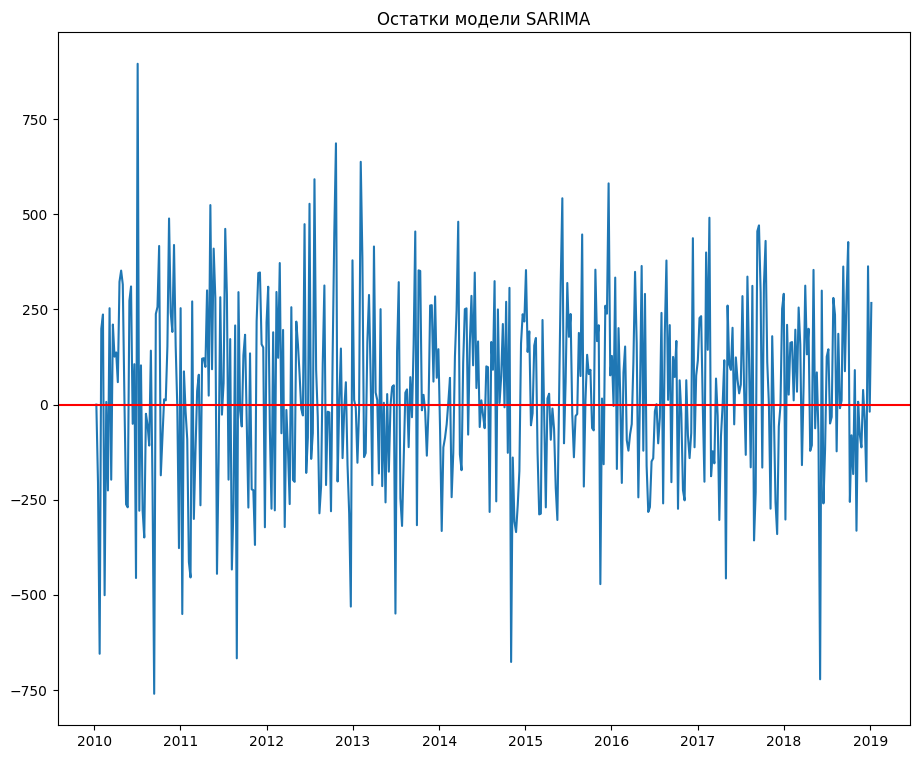

In [47]:
plt.plot(model.resid)
plt.title('Остатки модели SARIMA')
plt.axhline(y=0, color='r')
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mse = mean_squared_error(test_df_week, forecast_df_week)
mae = mean_absolute_error(test_df_week, forecast_df_week)
r2 = r2_score(test_df_week, forecast_df_week)

print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")

MSE: 106696.24031670975, MAE: 270.2995968239342, R^2: 0.9731593424773843




*   ARIMA   MSE: 111969.61112906634, MAE: 274.55492254361434, R^2: 0.971832765837532
*   SARIMA MSE: 106696.24031670975, MAE: 270.2995968239342, R^2: 0.9731593424773843

SARIMA оказалась чуть лучше


